# Discrete Event Simulation (DES) of an Automated Teller Machine (ATM)

## Introduction
This activity introduces the concept of Discrete Event Simulation (DES) by modeling the operations of an Automated Teller Machine (ATM) system. You will learn how to simulate customer arrivals, ATM service, and various scenarios that can occur during a transaction, such as insufficient cash in the ATM, customer insufficient funds, and specific withdrawal denominations.


## Learning Objectives
Upon completion of this activity, you should be able to:
- Understand the basic principles of Discrete Event Simulation.
- Model a real-world system (ATM) using DES concepts.
- Implement event-driven simulation logic.
- Handle various scenarios and conditions within a simulation.
- Analyze and interpret simulation results.


## Problem Description: ATM Simulation

Simulate a bank with 3 ATM machines. The simulation should model customer interactions with the ATMs, considering the following scenarios:

### ATM Constraints and Scenarios:
1.  **Cash Dispensing Issues**: An ATM may not be able to dispense money due to:
    *   **No Available Cash**: The ATM has run out of cash.
    *   **Large Withdrawal Amount**: The customer attempts to withdraw an amount larger than the ATM's current cash reserves, or an amount that cannot be dispensed with available denominations.
    *   If an ATM cannot dispense the requested amount, the customer should attempt to use another available machine or re-enter the amount.
2.  **Customer Insufficient Funds**: A customer may have insufficient funds in their account to complete a withdrawal. In this case, the transaction should be declined.
3.  **Paper Money Denominations**: Customers can only withdraw money in denominations of 100, 500, and 1000.

### Simulation Requirements:
-   Model customer arrivals as a random process.
-   Model ATM service time.
-   Keep track of the state of each ATM (available, busy, out of cash).
-   Record key metrics such as:
    *   Average customer waiting time.
    *   Number of customers served.
    *   Number of rejected transactions (due to ATM cash, customer funds, or denomination issues).
    *   ATM utilization.


## Task: Data Visualization

To enhance the analysis of the ATM simulation, create meaningful plots and graphs based on the collected simulation metrics. The more visualizations, the better. Consider the following:

-   **Create Simulation Assumptions**: Formulate 5 clear and concise assumptions that underpin your simulation model. These assumptions should address aspects not explicitly defined in the problem description but are necessary for the simulation to run.
-   **Customer Waiting Time Distribution**: A histogram or density plot to show the distribution of customer waiting times.
-   **ATM Utilization**: A bar chart or pie chart showing the utilization of each ATM.
-   **Transaction Outcomes**: A bar chart or pie chart illustrating the proportion of successful transactions versus rejected transactions (categorized by reason: insufficient funds, ATM cash issues, no available ATM).
-   **Cash Remaining in ATMs**: A plot showing the cash level in each ATM over time (if time-series data is collected).
-   **Customers Served Over Time**: A line graph showing the cumulative number of customers served over the simulation duration.

Implement the code to generate these plots using appropriate Python libraries (e.g., `matplotlib`, `seaborn`, `plotly`).

SEE THE EXAMPLE PLOTS BELOW

In [2]:
import simpy
import random
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.patches import Wedge

# --- Configuration Parameters ---
RANDOM_SEED = random.randint(1, 10000)
NUM_ATMS = 5  # Number of ATM machines
ATM_CAPACITY = 200000  # Each ATM starts with 200,000 units of cash
DISPENSE_SERVICE_TIME = 0.10  # Time to dispense money (per Bank Note)
MIN_WITHDRAWAL = 1000
MAX_WITHDRAWAL = 10000
CUSTOMER_ARRIVAL_INTERVAL = 10  # Average time between customer arrivals (minutes)
SIM_DURATION = 1000  # Simulation duration (minutes)

DENOMINATIONS = [1000, 500, 100]
CUSTOMER_FUNDS_RANGE = (1000, 100000) # Customers have between 1,000 and 100,000 in their account

# Set up random seed for reproducibility
random.seed(RANDOM_SEED)

In [3]:
# Enhanced metrics collection
class EnhancedMetrics:
    def __init__(self):
        self.customers_arrived = 0
        self.customers_served = 0
        self.rejected_insufficient_funds = 0
        self.rejected_atm_issues = 0
        self.rejected_no_available_atm = 0
        self.customer_waiting_times = []
        self.transaction_times = []
        self.atm_cash_over_time = []
        self.customers_served_over_time = []
        self.withdrawal_amounts = []
        self.successful_transactions_over_time = []

class ATM:
    def __init__(self, env, name, capacity):
        self.env = env
        self.name = name
        self.cash = simpy.Container(env, init=capacity, capacity=capacity)
        self.total_dispensed = 0
        self.transactions_completed = 0

    def dispense_cash(self, amount):
        yield self.env.timeout(amount * DISPENSE_SERVICE_TIME / 100)
        yield self.cash.get(amount)
        self.total_dispensed += amount
        self.transactions_completed += 1

    def check_and_dispense(self, amount):
        if self.cash.level < amount:
            return False, "ATM has insufficient cash."

        # Check if amount can be dispensed with available denominations
        temp_amount = amount
        for denom in sorted(DENOMINATIONS, reverse=True):
            while temp_amount >= denom and temp_amount > 0:
                temp_amount -= denom
        if temp_amount != 0:
            return False, "Cannot dispense exact amount with available denominations."

        return True, "Cash can be dispensed."

In [4]:
def customer(env, name, atm_store, metrics):
    arrival_time = env.now
    print(f"{env.now:.2f}: Customer {name} arrived.")
    metrics.customers_arrived += 1

    withdrawal_amount = random.choice(DENOMINATIONS) * random.randint(1, 50)
    customer_funds = random.randint(*CUSTOMER_FUNDS_RANGE)

    print(f"{env.now:.2f}: Customer {name} wants to withdraw {withdrawal_amount} (has {customer_funds}).")

    if customer_funds < withdrawal_amount:
        print(f"{env.now:.2f}: Customer {name} has insufficient funds. Transaction rejected.")
        metrics.rejected_insufficient_funds += 1
        metrics.customer_waiting_times.append(env.now - arrival_time)
        return

    # Customer tries to withdraw, potentially trying multiple ATMs
    transaction_successful = False
    attempts = 0
    while not transaction_successful and attempts < NUM_ATMS:
        attempts += 1
        print(f"{env.now:.2f}: Customer {name} waiting for an ATM (attempt {attempts}/{NUM_ATMS}).")
        
        with atm_store.get() as get_atm_request:
            atm = yield get_atm_request

            print(f"{env.now:.2f}: Customer {name} got ATM {atm.name}.")
            
            can_dispense, reason = atm.check_and_dispense(withdrawal_amount)
            if can_dispense:
                print(f"{env.now:.2f}: Customer {name} using ATM {atm.name} to withdraw {withdrawal_amount}.")
                yield env.process(atm.dispense_cash(withdrawal_amount))
                print(f"{env.now:.2f}: Customer {name} successfully withdrew {withdrawal_amount} from ATM {atm.name}. Remaining cash: {atm.cash.level}")
                metrics.customers_served += 1
                metrics.withdrawal_amounts.append(withdrawal_amount)
                metrics.customer_waiting_times.append(env.now - arrival_time)
                metrics.transaction_times.append(env.now)
                transaction_successful = True
            else:
                print(f"{env.now:.2f}: ATM {atm.name} cannot dispense for Customer {name}: {reason}")
                metrics.rejected_atm_issues += 1
                print(f"{env.now:.2f}: Customer {name} returning ATM {atm.name} and will try another.")
            
            yield atm_store.put(atm)

        if not transaction_successful and attempts < NUM_ATMS:
            yield env.timeout(1)
    
    if not transaction_successful:
        print(f"{env.now:.2f}: Customer {name} could not withdraw from any ATM after {NUM_ATMS} attempts and left.")
        metrics.rejected_no_available_atm += 1
        metrics.customer_waiting_times.append(env.now - arrival_time)
    else:
        print(f"{env.now:.2f}: Customer {name} completed transaction.")

In [5]:
def data_collector(env, atms, metrics):
    """Collect time-series data throughout simulation"""
    while True:
        # Record ATM cash levels
        cash_snapshot = {
            'time': env.now,
            **{f'{atm.name}_cash': atm.cash.level for atm in atms}
        }
        metrics.atm_cash_over_time.append(cash_snapshot)
        
        # Record cumulative customers served
        metrics.customers_served_over_time.append({
            'time': env.now,
            'customers_served': metrics.customers_served
        })
        
        yield env.timeout(10)  # Collect data every 10 minutes

--- Enhanced ATM Simulation with Data Visualization ---
28.98: Customer 1 arrived.
28.98: Customer 1 wants to withdraw 10500 (has 25152).
28.98: Customer 1 waiting for an ATM (attempt 1/5).
28.98: Customer 1 got ATM ATM 1.
28.98: Customer 1 using ATM ATM 1 to withdraw 10500.
30.57: Customer 2 arrived.
30.57: Customer 2 wants to withdraw 3800 (has 90672).
30.57: Customer 2 waiting for an ATM (attempt 1/5).
30.57: Customer 2 got ATM ATM 2.
30.57: Customer 2 using ATM ATM 2 to withdraw 3800.
34.37: Customer 2 successfully withdrew 3800 from ATM ATM 2. Remaining cash: 196200
34.37: Customer 2 completed transaction.
39.48: Customer 1 successfully withdrew 10500 from ATM ATM 1. Remaining cash: 189500
39.48: Customer 1 completed transaction.
67.24: Customer 3 arrived.
67.24: Customer 3 wants to withdraw 5500 (has 92653).
67.24: Customer 3 waiting for an ATM (attempt 1/5).
67.24: Customer 3 got ATM ATM 3.
67.24: Customer 3 using ATM ATM 3 to withdraw 5500.
72.74: Customer 3 successfully withdr

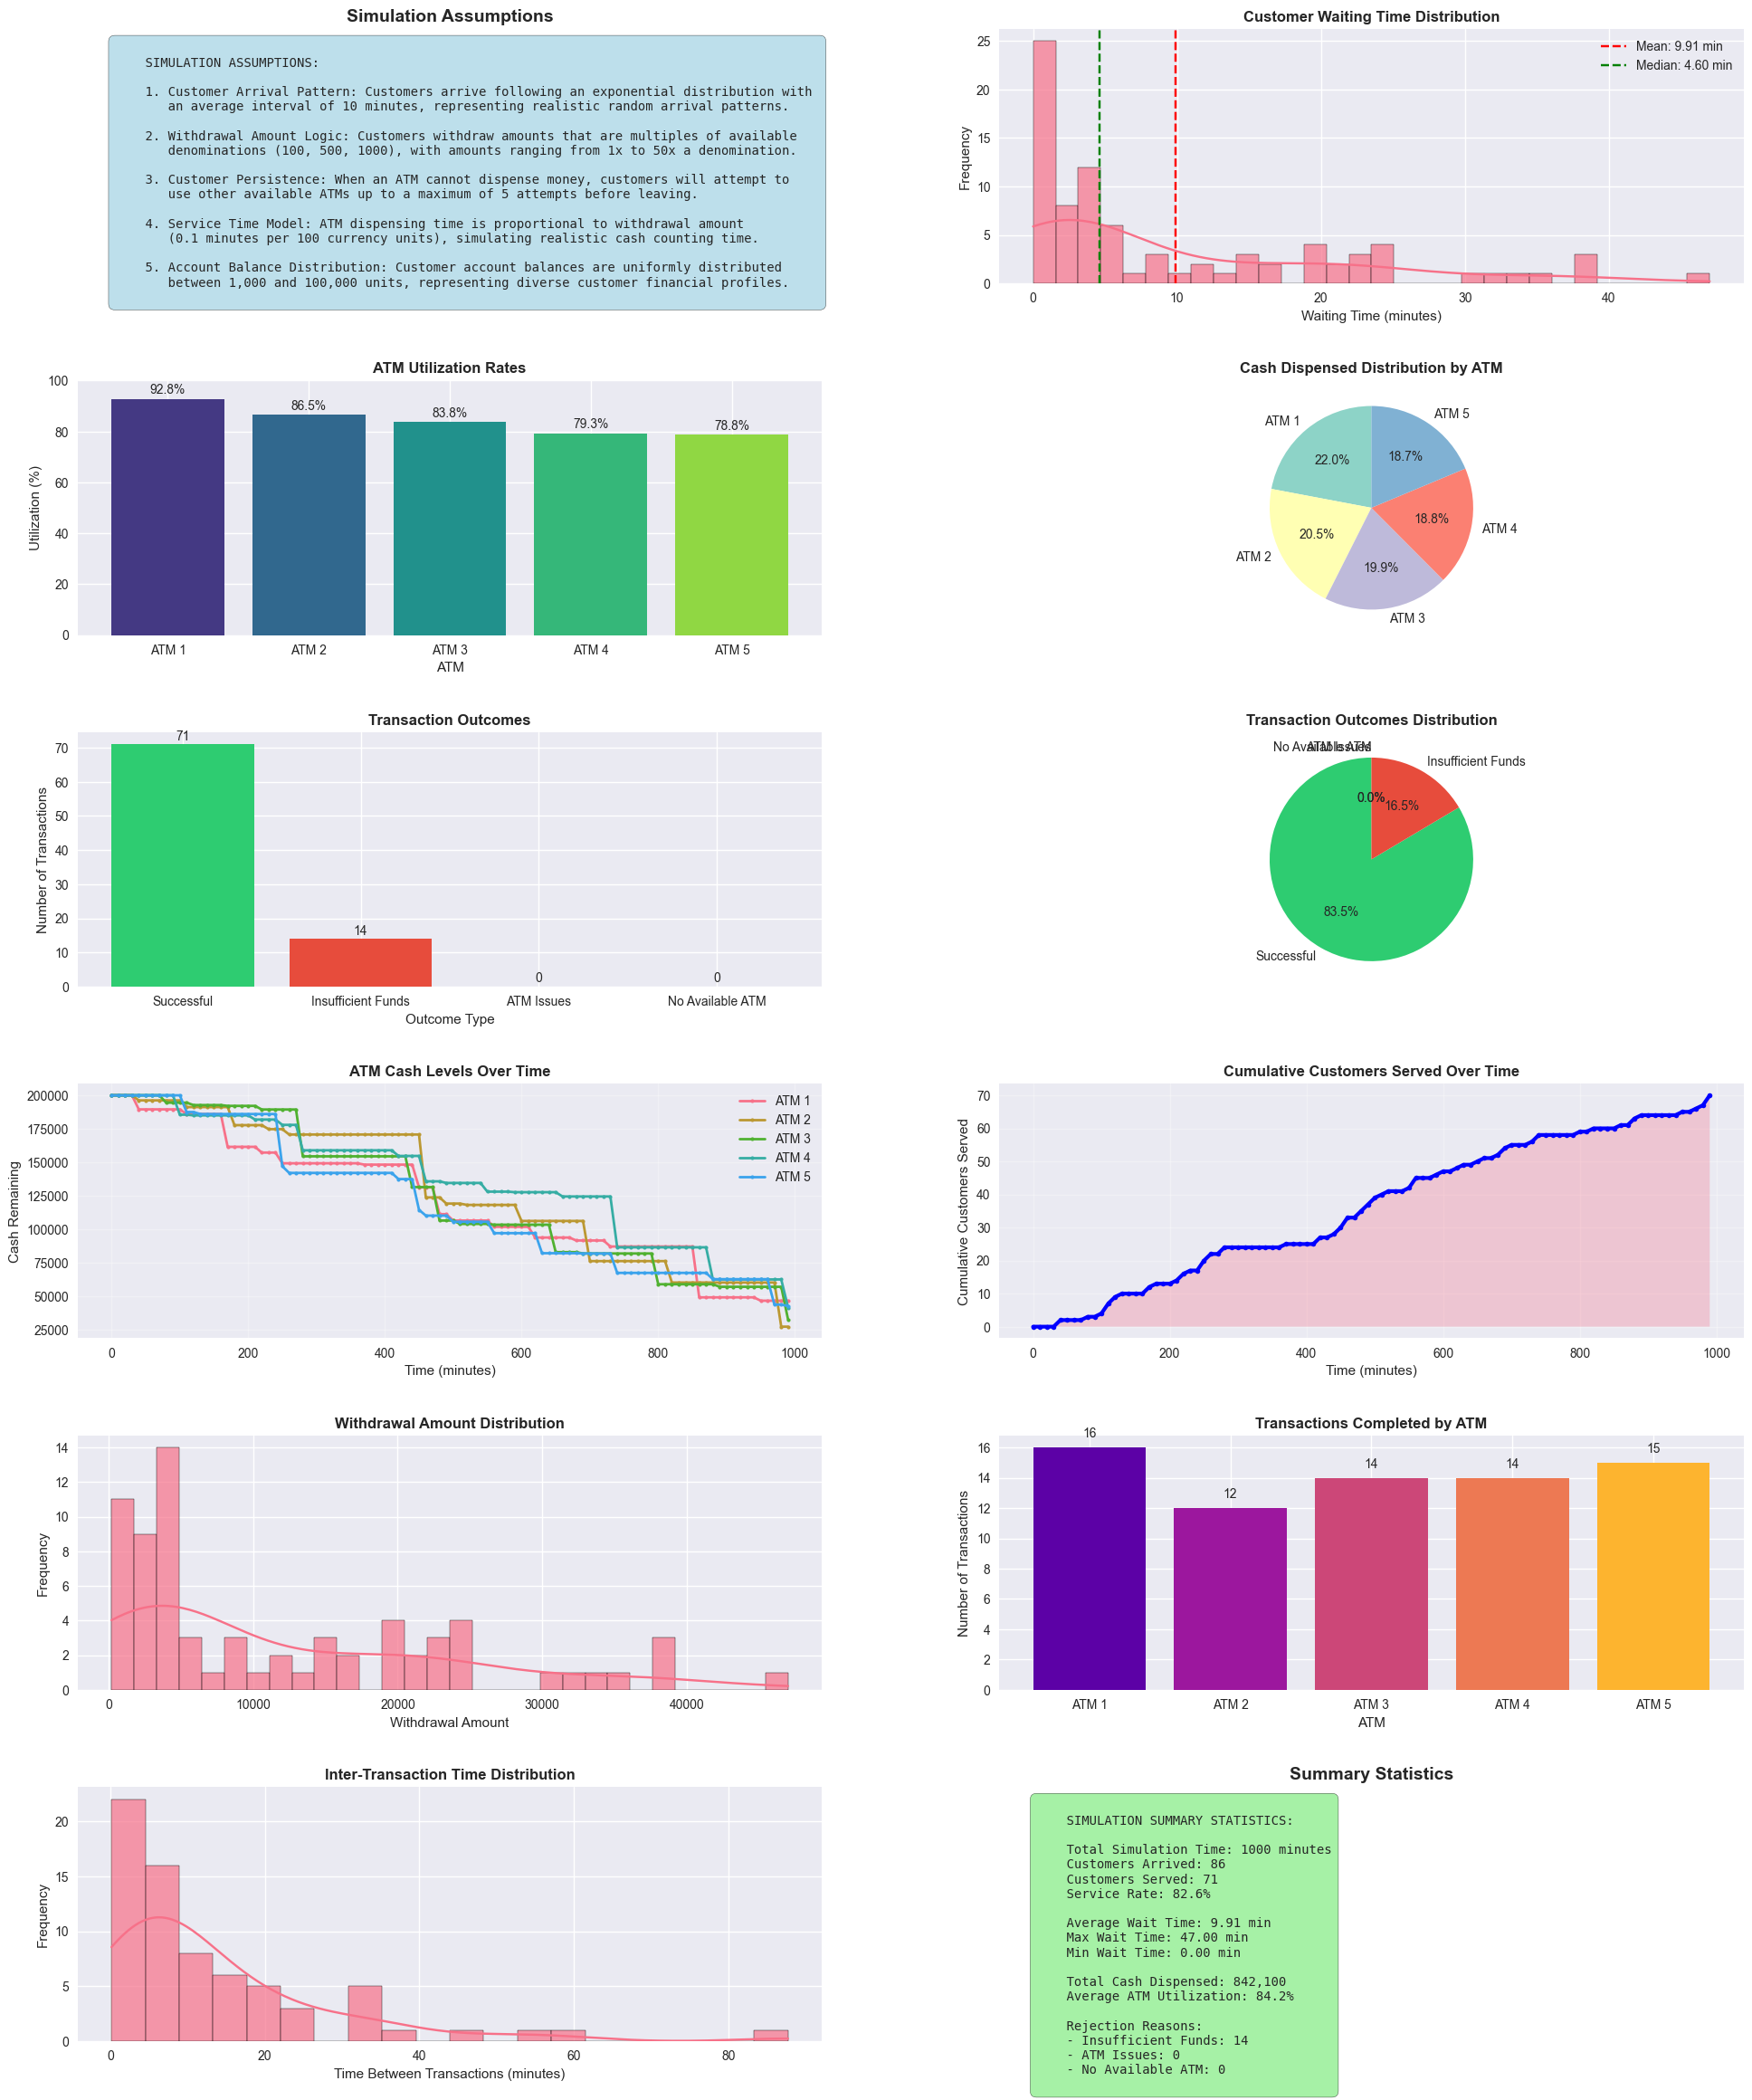

In [6]:
def customer_generator(env, atm_store, metrics, arrival_interval):
    i = 0
    while True:
        yield env.timeout(random.expovariate(1.0 / arrival_interval))
        i += 1
        env.process(customer(env, f'{i}', atm_store, metrics))

def setup_environment(env, num_atms, atm_capacity):
    atms = [ATM(env, f'ATM {i+1}', atm_capacity) for i in range(num_atms)]
    atm_store = simpy.Store(env)
    for atm in atms:
        atm_store.put(atm)
    metrics = EnhancedMetrics()
    return atms, atm_store, metrics

def create_visualizations(atms, metrics):
    """Create comprehensive visualization suite"""
    
    # Set style
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 24))
    
    # 1. Simulation Assumptions
    assumptions_text = """
    SIMULATION ASSUMPTIONS:
    
    1. Customer Arrival Pattern: Customers arrive following an exponential distribution with 
       an average interval of 10 minutes, representing realistic random arrival patterns.
    
    2. Withdrawal Amount Logic: Customers withdraw amounts that are multiples of available 
       denominations (100, 500, 1000), with amounts ranging from 1x to 50x a denomination.
    
    3. Customer Persistence: When an ATM cannot dispense money, customers will attempt to 
       use other available ATMs up to a maximum of 5 attempts before leaving.
    
    4. Service Time Model: ATM dispensing time is proportional to withdrawal amount 
       (0.1 minutes per 100 currency units), simulating realistic cash counting time.
    
    5. Account Balance Distribution: Customer account balances are uniformly distributed 
       between 1,000 and 100,000 units, representing diverse customer financial profiles.
    """
    
    ax_assumptions = plt.subplot(6, 2, 1)
    ax_assumptions.text(0.05, 0.95, assumptions_text, transform=ax_assumptions.transAxes, 
                       fontsize=10, verticalalignment='top', fontfamily='monospace',
                       bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    ax_assumptions.set_xlim(0, 1)
    ax_assumptions.set_ylim(0, 1)
    ax_assumptions.axis('off')
    ax_assumptions.set_title('Simulation Assumptions', fontsize=14, fontweight='bold')
    
    # 2. Customer Waiting Time Distribution
    ax1 = plt.subplot(6, 2, 2)
    if metrics.customer_waiting_times:
        sns.histplot(metrics.customer_waiting_times, bins=30, kde=True, ax=ax1, alpha=0.7)
        ax1.axvline(np.mean(metrics.customer_waiting_times), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(metrics.customer_waiting_times):.2f} min')
        ax1.axvline(np.median(metrics.customer_waiting_times), color='green', linestyle='--', 
                   label=f'Median: {np.median(metrics.customer_waiting_times):.2f} min')
        ax1.legend()
    ax1.set_title('Customer Waiting Time Distribution', fontweight='bold')
    ax1.set_xlabel('Waiting Time (minutes)')
    ax1.set_ylabel('Frequency')
    
    # 3. ATM Utilization (Bar Chart)
    ax2 = plt.subplot(6, 2, 3)
    atm_names = [atm.name for atm in atms]
    utilization_rates = [(atm.total_dispensed / ATM_CAPACITY) * 100 for atm in atms]
    bars = ax2.bar(atm_names, utilization_rates, color=sns.color_palette("viridis", len(atms)))
    ax2.set_title('ATM Utilization Rates', fontweight='bold')
    ax2.set_xlabel('ATM')
    ax2.set_ylabel('Utilization (%)')
    ax2.set_ylim(0, 100)
    
    # Add value labels on bars
    for bar, rate in zip(bars, utilization_rates):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{rate:.1f}%', ha='center', va='bottom')
    
    # 4. ATM Utilization (Pie Chart)
    ax3 = plt.subplot(6, 2, 4)
    cash_dispensed = [atm.total_dispensed for atm in atms]
    colors = sns.color_palette("Set3", len(atms))
    wedges, texts, autotexts = ax3.pie(cash_dispensed, labels=atm_names, autopct='%1.1f%%', 
                                      colors=colors, startangle=90)
    ax3.set_title('Cash Dispensed Distribution by ATM', fontweight='bold')
    
    # 5. Transaction Outcomes
    ax4 = plt.subplot(6, 2, 5)
    outcomes = {
        'Successful': metrics.customers_served,
        'Insufficient Funds': metrics.rejected_insufficient_funds,
        'ATM Issues': metrics.rejected_atm_issues,
        'No Available ATM': metrics.rejected_no_available_atm
    }
    
    colors_outcomes = ['#2ecc71', '#e74c3c', '#f39c12', '#9b59b6']
    bars_outcomes = ax4.bar(outcomes.keys(), outcomes.values(), color=colors_outcomes)
    ax4.set_title('Transaction Outcomes', fontweight='bold')
    ax4.set_xlabel('Outcome Type')
    ax4.set_ylabel('Number of Transactions')
    
    # Add value labels
    for bar, value in zip(bars_outcomes, outcomes.values()):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{value}', ha='center', va='bottom')
    
    # 6. Transaction Outcomes (Pie Chart)
    ax5 = plt.subplot(6, 2, 6)
    wedges, texts, autotexts = ax5.pie(outcomes.values(), labels=outcomes.keys(), 
                                      autopct='%1.1f%%', colors=colors_outcomes, startangle=90)
    ax5.set_title('Transaction Outcomes Distribution', fontweight='bold')
    
    # 7. Cash Remaining in ATMs Over Time
    ax6 = plt.subplot(6, 2, 7)
    if metrics.atm_cash_over_time:
        df_cash = pd.DataFrame(metrics.atm_cash_over_time)
        for atm in atms:
            column_name = f'{atm.name}_cash'
            if column_name in df_cash.columns:
                ax6.plot(df_cash['time'], df_cash[column_name], 
                        label=atm.name, marker='o', markersize=3, linewidth=2)
        
        ax6.set_title('ATM Cash Levels Over Time', fontweight='bold')
        ax6.set_xlabel('Time (minutes)')
        ax6.set_ylabel('Cash Remaining')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
    
    # 8. Customers Served Over Time
    ax7 = plt.subplot(6, 2, 8)
    if metrics.customers_served_over_time:
        df_served = pd.DataFrame(metrics.customers_served_over_time)
        ax7.plot(df_served['time'], df_served['customers_served'], 
                color='blue', linewidth=3, marker='o', markersize=4)
        ax7.fill_between(df_served['time'], df_served['customers_served'], alpha=0.3)
        ax7.set_title('Cumulative Customers Served Over Time', fontweight='bold')
        ax7.set_xlabel('Time (minutes)')
        ax7.set_ylabel('Cumulative Customers Served')
        ax7.grid(True, alpha=0.3)
    
    # 9. Withdrawal Amount Distribution
    ax8 = plt.subplot(6, 2, 9)
    if metrics.withdrawal_amounts:
        sns.histplot(metrics.withdrawal_amounts, bins=30, kde=True, ax=ax8, alpha=0.7)
        ax8.set_title('Withdrawal Amount Distribution', fontweight='bold')
        ax8.set_xlabel('Withdrawal Amount')
        ax8.set_ylabel('Frequency')
    
    # 10. ATM Transaction Count Comparison
    ax9 = plt.subplot(6, 2, 10)
    transaction_counts = [atm.transactions_completed for atm in atms]
    bars_trans = ax9.bar(atm_names, transaction_counts, color=sns.color_palette("plasma", len(atms)))
    ax9.set_title('Transactions Completed by ATM', fontweight='bold')
    ax9.set_xlabel('ATM')
    ax9.set_ylabel('Number of Transactions')
    
    # Add value labels
    for bar, count in zip(bars_trans, transaction_counts):
        height = bar.get_height()
        ax9.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{count}', ha='center', va='bottom')
    
    # 11. Service Time Analysis
    ax10 = plt.subplot(6, 2, 11)
    if metrics.transaction_times:
        # Calculate time between transactions
        service_intervals = np.diff(metrics.transaction_times)
        if len(service_intervals) > 0:
            sns.histplot(service_intervals, bins=20, kde=True, ax=ax10, alpha=0.7)
            ax10.set_title('Inter-Transaction Time Distribution', fontweight='bold')
            ax10.set_xlabel('Time Between Transactions (minutes)')
            ax10.set_ylabel('Frequency')
    
    # 12. Summary Statistics
    ax11 = plt.subplot(6, 2, 12)
    summary_stats = f"""
    SIMULATION SUMMARY STATISTICS:
    
    Total Simulation Time: {SIM_DURATION} minutes
    Customers Arrived: {metrics.customers_arrived}
    Customers Served: {metrics.customers_served}
    Service Rate: {(metrics.customers_served/metrics.customers_arrived)*100:.1f}%
    
    Average Wait Time: {np.mean(metrics.customer_waiting_times):.2f} min
    Max Wait Time: {max(metrics.customer_waiting_times):.2f} min
    Min Wait Time: {min(metrics.customer_waiting_times):.2f} min
    
    Total Cash Dispensed: {sum(atm.total_dispensed for atm in atms):,}
    Average ATM Utilization: {np.mean(utilization_rates):.1f}%
    
    Rejection Reasons:
    - Insufficient Funds: {metrics.rejected_insufficient_funds}
    - ATM Issues: {metrics.rejected_atm_issues}  
    - No Available ATM: {metrics.rejected_no_available_atm}
    """
    
    ax11.text(0.05, 0.95, summary_stats, transform=ax11.transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8))
    ax11.set_xlim(0, 1)
    ax11.set_ylim(0, 1)
    ax11.axis('off')
    ax11.set_title('Summary Statistics', fontsize=14, fontweight='bold')
    
    plt.tight_layout(pad=3.0)
    plt.show()

# Run the enhanced simulation
print("--- Enhanced ATM Simulation with Data Visualization ---")
env = simpy.Environment()
atms, atm_store, metrics = setup_environment(env, NUM_ATMS, ATM_CAPACITY)

# Start processes
env.process(customer_generator(env, atm_store, metrics, CUSTOMER_ARRIVAL_INTERVAL))
env.process(data_collector(env, atms, metrics))

# Run simulation
env.run(until=SIM_DURATION)

# Print basic metrics
print("\n--- Basic Simulation Metrics ---")
print(f"Customers Arrived: {metrics.customers_arrived}")
print(f"Customers Served: {metrics.customers_served}")
print(f"Rejected (Insufficient Funds): {metrics.rejected_insufficient_funds}")
print(f"Rejected (ATM Issues): {metrics.rejected_atm_issues}")
print(f"Rejected (No Available ATM): {metrics.rejected_no_available_atm}")

if metrics.customer_waiting_times:
    avg_wait_time = sum(metrics.customer_waiting_times) / len(metrics.customer_waiting_times)
    print(f"Average Customer Waiting Time: {avg_wait_time:.2f} minutes")

for atm in atms:
    cash_dispensed = atm.total_dispensed
    utilization = (cash_dispensed / ATM_CAPACITY) * 100
    print(f"{atm.name} Cash Remaining: {atm.cash.level} (Dispensed: {cash_dispensed}) - Utilization: {utilization:.1f}%")

# Generate comprehensive visualizations
create_visualizations(atms, metrics)

The various graphs above shows the results of an **ATM system simulation**, covering assumptions, performance metrics, customer behaviors, and ATM usage patterns.

---

### **1. Simulation Assumptions**
- **Customer arrivals** follow an exponential distribution (random arrival pattern).
- **Withdrawals** are multiples of available denominations (100, 500, 1000).
- **Persistence:** If an ATM is out of cash, customers retry up to 5 times.
- **ATM speed:** Dispensing time scales with withdrawal amount.
- **Balances:** Customers have diverse financial profiles.

---

### **2. Customer Waiting Times**
- **Distribution:** Most customers wait less than 10 minutes.
- **Median wait:** ~4.6 minutes (green line).
- **Mean wait:** ~9.9 minutes (red line).
- Some outliers waited over 40 minutes.

---

### **3. ATM Utilization Rates**
- Highest: **ATM 1 (~92.8%)**  
- Lowest: **ATM 5 (~78.8%)**  
- Overall: ATMs are **heavily used**, with utilization between 78–93%.

---

### **4. Transaction Outcomes**
- **Successful:** 71  
- **Insufficient funds:** 14  
- **ATM issues:** 0  
- **No ATM available:** 0  
- Pie chart confirms: **83.5% successful transactions**.

---

### **5. Cash Dispensed Distribution**
- Dispensing load is **fairly balanced**:
  - ATM 1 & 2 handle ~22.0% and 20.5% each.
  - ATM 3, 4, 5 each handle ~18.7%, 18.8%, 19.9% respectively.

---

### **6. ATM Cash Levels Over Time**
- All ATMs **gradually deplete cash** as time progresses.
- Patterns show **stepwise drops** (discrete withdrawals).
- Around the **end of the simulation**, several ATMs approach depletion.

---

### **7. Cumulative Customers Served Over Time**
- Smooth **upward growth**, no major service halts.
- ~70 customers served by the end of 1000 minutes.

---

### **8. Withdrawal Amount Distribution**
- Most withdrawals are **small ( less than 10,000 units)**.
- Fewer customers withdraw large amounts (20,000–50,000 units).

---

### **9. Inter-Transaction Time Distribution**
- Many customers transact **within 5–10 minutes of each other**.
- Long gaps between transactions are rare.

---

### **10. Transactions Completed per ATM**
- ATM 1: 16  
- ATM 2: 12  
- ATM 3 & 4: 14 each  
- ATM 5: 15  
- Fairly balanced, but ATM 1 slightly higher.

---

### **11. Summary Statistics**
- **Simulation time:** 1000 minutes.
- **Customers arrived:** 86.
- **Served:** 71.
- **Rejected:** 14 (all insufficient funds).
- **Average wait time:** 9.91 minutes.
- **Max wait:** 47 minutes.
- **Min wait:** 0 minutes.
- **Cash dispensed:** ~842,100 units.
- **Average ATM utilization:** 84.2%.

---

✅ **Takeaway:**
- The system handled demand well, with **high ATM utilization** and **low rejection rates** (only due to insufficient customer funds, not ATM issues).  
- **Waiting times are reasonable**, though a few customers experienced long delays.  
- **Cash distribution was balanced** across ATMs, suggesting no single ATM was overloaded.  

---